   time in min  (S)-3-OH-PAC    3-OH-BA  3-OH-BA-forged-1  3-OH-BA-forged-2  \
0          0.0      0.031101  10.891257         11.220156         10.713346   
1          0.5      1.883719   8.977816          9.623000          8.282877   
2          1.0      3.631862   7.306264          8.211833          6.484533   
3          1.5      5.212020   5.731909          6.441315          5.560666   
4          2.0      6.713972   4.349994          4.727210          4.168047   

   (R)-3-OH-PAC  (S)-3-OH-PAC.1  3-OH-BA.1  (R)-3-OH-PAC.1  
0           0.0        0.027853   0.059094             0.0  
1           0.0        0.077991   0.093238             0.0  
2           0.0        0.143958   0.114549             0.0  
3           0.0        0.143394   0.131286             0.0  
4           0.0        0.240008   0.170337             0.0  
Index(['time in min', '(S)-3-OH-PAC', '3-OH-BA', '3-OH-BA-forged-1',
       '3-OH-BA-forged-2', '(R)-3-OH-PAC', '(S)-3-OH-PAC.1', '3-OH-BA.1',
       '(R)-3-OH

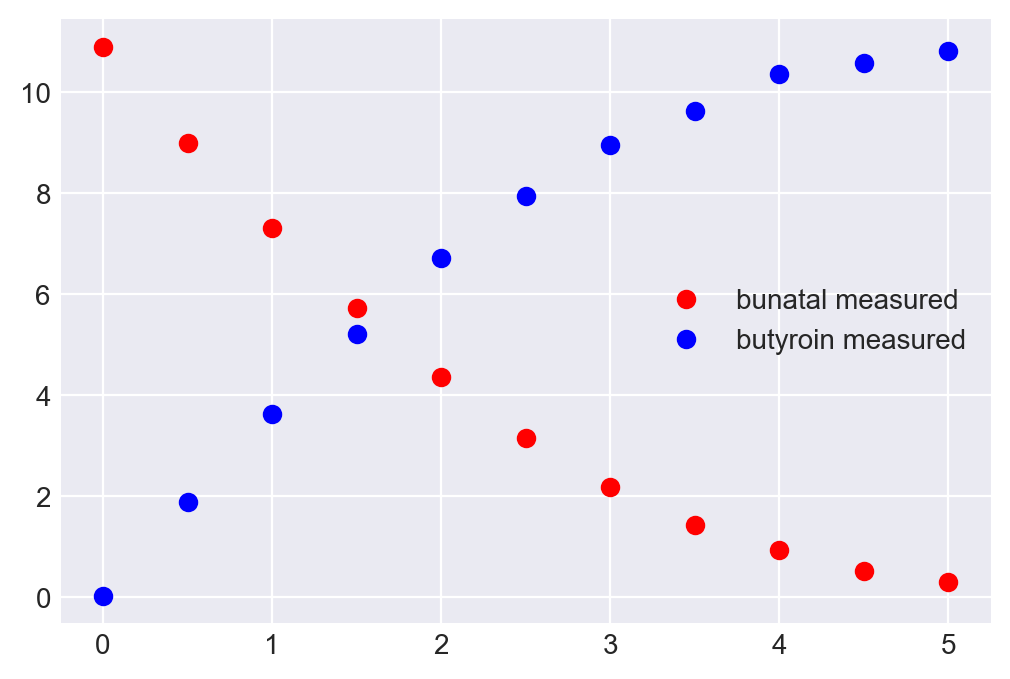

In [6]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 200
print(df.head())
print(df.columns)


time = df["time in min"]
substrate = df["3-OH-BA"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
product_before_feed = product.iloc[:11]

fix, ax = plt.subplots()

ax.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="butyroin measured", color="blue", linestyle="", marker="o")
#ax.plot(time, product2, label="octanediol measured", color="green", linestyle="", marker="o")
ax.legend()





[[10.89125651  8.97781629  7.30626428  5.73190936  4.34999448  3.14620345
   2.18897357  1.4283044   0.92770542  0.51440539  0.30357097]
 [ 0.03110091  1.88371882  3.63186183  5.21201965  6.71397226  7.93279586
   8.95364052  9.62457475 10.35836504 10.57652435 10.81390784]]
[11, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 22
    # variables        = 2
    chi-square         = 5.72100254
    reduced chi-square = 0.28605013
    Akaike info crit   = -25.6317647
    Bayesian info crit = -23.4496798
[[Variables]]
    kA:  0.50834051 +/- 0.03338610 (6.57%) (init = 2)
    kP:  1.3747e-10 +/- 0.10186993 (74102301001.87%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kA, kP) = -0.831
None


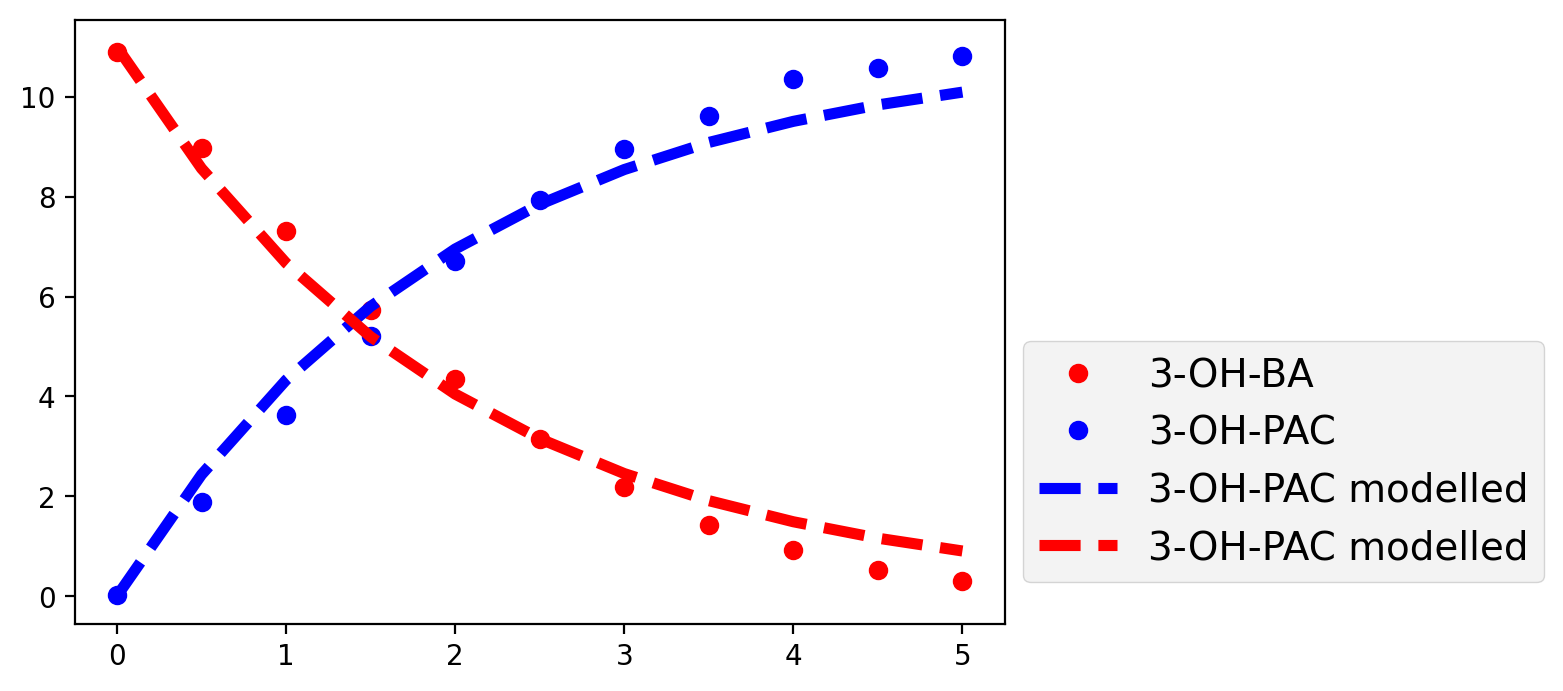

In [2]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

print(data)

y0_array = [11, 0]
print(y0_array)

def dadt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt

def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dadt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

#sol = odeint(dglsys, y0_array, time_before_feed, args=(0.50834051, 0.000000000137))
sol = odeint(dglsys, y0_array, time_before_feed, args=(0.5, 0.00005))

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel=odeint(dglsys, y0_array, time_before_feed, args=(kA, kP))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    result = [substr, product] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time_before_feed), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(time_before_feed, substrate_before_feed, label="3-OH-BA", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="3-OH-PAC", color="blue", linestyle="", marker="o")

ax.plot(time_before_feed, sol[:,1], label="3-OH-PAC modelled", linestyle="--", color="blue")
ax.plot(time_before_feed, sol[:,0], label="3-OH-PAC modelled", linestyle="--", color="red")


ax.legend(loc=9, bbox_to_anchor=(1.3,0.5))
plt.savefig("testfig.svg", format="svg")
plt.show()

In [7]:
# Test with PyMC3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

y0_array = np.array([11, 0])
y0 = [20]

def dadt(y, t, p):
    dadt = -p[0]*y[0] + p[1]*y[0]
    return dadt

# test data
substrates = np.reshape(np.array(substrate_before_feed), (11, 1))
time = np.array(time_before_feed)

# time array needs the shape (,11) and the data (11,1) 

ode_model = DifferentialEquation(func=dadt, times=time, n_states=1, n_theta=2)


with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    init = pm.Normal("init",11, 1)
    Kb = pm.Uniform("Kb", 0, 0.000000001)
    sigma = pm.Normal("sigma", 0.1)

    ode_solution = ode_model(y0=[11], theta=[Ka, Kb])
    # man kann die ode solutions slicen
    ode_solution_s = ode_solution[:,0]

    # The ode_solution has a shape of (n_times, n_states)
    # hierarchical modelling 
    # Tensor variablen ansehen

    # Ode solution can be splitted in several likelihoods, however this works
    # murefi???????
    # Array broadcasting: Wenn man als µ einen Vektor reingibt, kann man als observed eine Matrix reingibt

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=substrates)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace,posterior_predictive=posterior_predictive)




c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, Kb, init, Ka]


c:\Users\SMalz\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\SMalz\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 256 seconds.


array([<AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'Ka'}>,
       <AxesSubplot:title={'center':'Kb'}>], dtype=object)

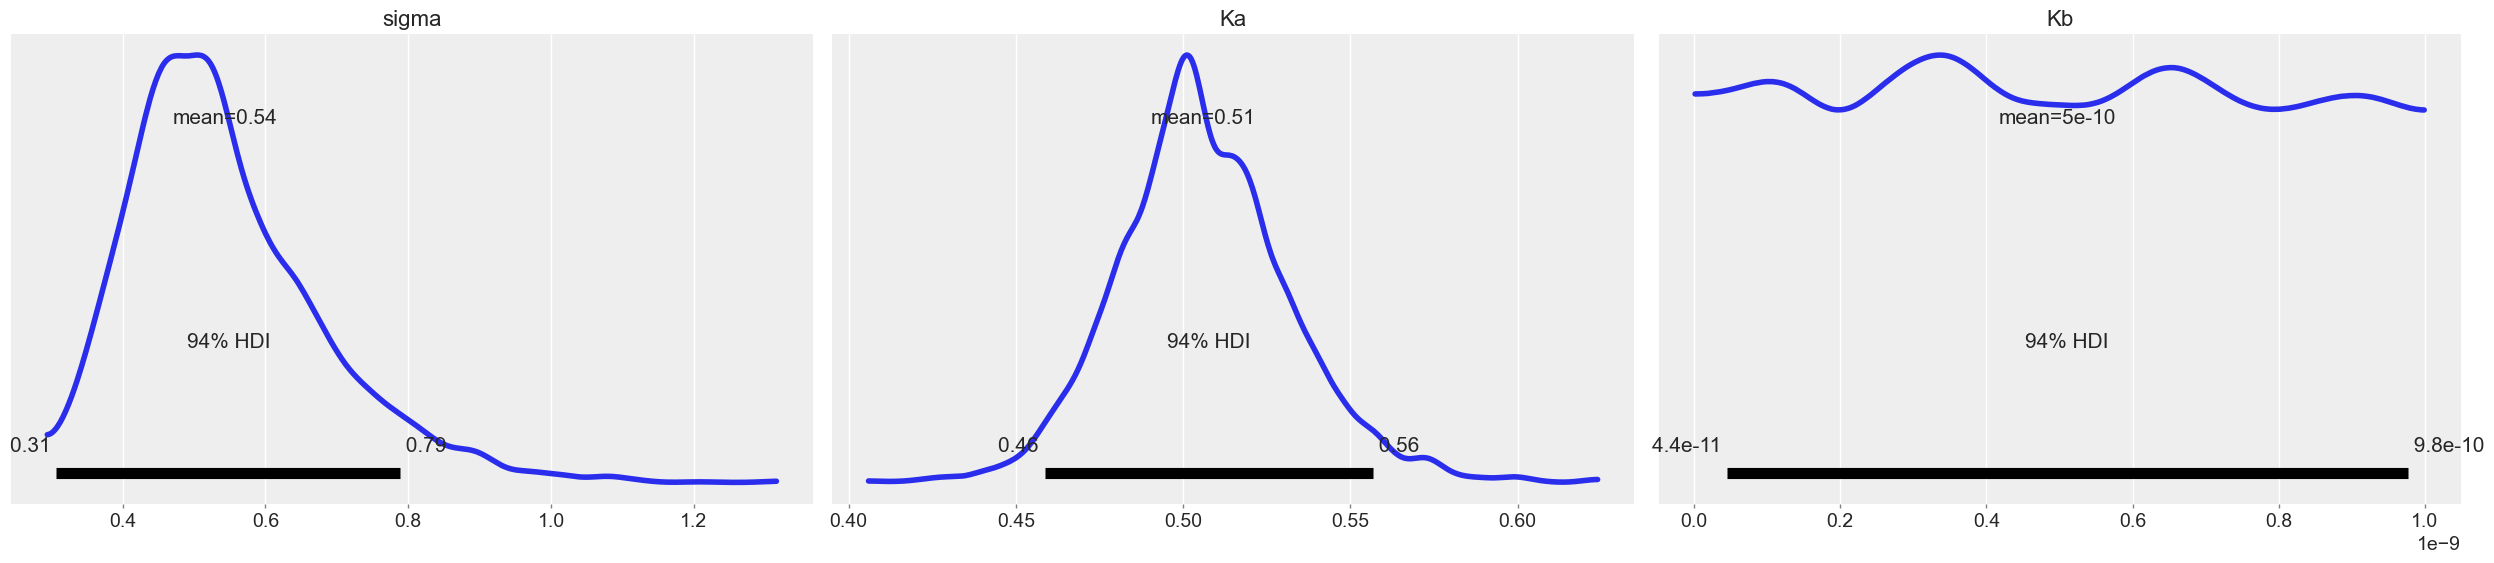

In [19]:
az.plot_posterior(data)

# Plot der Daten mit dem Verteilungen

# pm.gp.util.plot_gp_dist(Zeit, posteroirirgendwas)


In [3]:
# Test with PyMC3, more complex model 
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano


# Change algorithm - check wich algorithm is used
# explicit solver: runge kutta rk45 rk54

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

substratess=np.array(substrate_before_feed)
productss=np.array(product_before_feed)

data = np.column_stack((substratess,productss))
#print("die data sind",data)

y0_array = np.array([11, 0])
y0 = [20]


def dadt(y, t, p):
    dadt = -p[0]*y[0]
    #dbdt = p[0]*y[1] - p[1]*y[1]
    return dadt

# test data
substrates = np.reshape(np.array(substrate_before_feed), (11, 1))
time = np.array(time_before_feed)
print("time", time)

print(substrates)


# time array needs the shape (,11) and the data (11,1) 

ode_model = DifferentialEquation(func=dadt, times=time, n_states=1, n_theta=2)


with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    Kb = pm.Uniform("Kb", 0, 0.0001)
    sigma = pm.Normal("sigma", 0.1)

    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[11], theta=[Ka, Kb])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=substrates)
    print(type(Y))

    prior = pm.sample_prior_predictive(samples=50)
    trace = (pm.sample(2000, tune=1000, cores=1))
    posterior = (pm.sample_posterior_predictive(trace, var_names=["Y","Ka", "Kb", "sigma"]))

    #data = az.from_pymc3(trace = trace, prior = prior, posterior = posterior)



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


time [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[[10.89125651]
 [ 8.97781629]
 [ 7.30626428]
 [ 5.73190936]
 [ 4.34999448]
 [ 3.14620345]
 [ 2.18897357]
 [ 1.4283044 ]
 [ 0.92770542]
 [ 0.51440539]
 [ 0.30357097]]
<class 'pymc3.model.ObservedRV'>


c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, Kb, Ka]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 370 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
print("ode_solution is: ",ode_solution)
subtensor1 = ode_solution[0]
print(type(subtensor1))

print(subtensor1.__dict__)



#tensor = ode_solution[1:3]




ode_solution is:  DifferentialEquation{func=<function dadt at 0x000002607D237E58>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0), n_states=1, n_theta=2, t0=0}.0
<class 'theano.tensor.var.TensorVariable'>
{'tag': scratchpad{'attr': 'test_value', 'attr_filter': <bound method TensorType.filter of TensorType(float64, vector)>, 'trace': [[('c:\\Users\\SMalz\\anaconda3\\lib\\site-packages\\ipykernel\\zmqshell.py', 536, 'run_cell', 'return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)'), ('c:\\Users\\SMalz\\anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py', 2895, 'run_cell', 'raw_cell, store_history, silent, shell_futures)'), ('c:\\Users\\SMalz\\anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py', 2940, '_run_cell', 'return runner(coro)'), ('c:\\Users\\SMalz\\anaconda3\\lib\\site-packages\\IPython\\core\\async_helpers.py', 68, '_pseudo_sync_runner', 'coro.send(None)'), ('c:\\Users\\SMalz\\anaconda3\\lib\\site-packages\\IPython\\core

dict_keys(['Ka', 'Kb', 'sigma'])
[0.49447989 0.49447989 0.49447989 ... 0.48999477 0.47864913 0.49730285]


KeyError: 'var names: "[\'Y\'] are not present" in dataset'

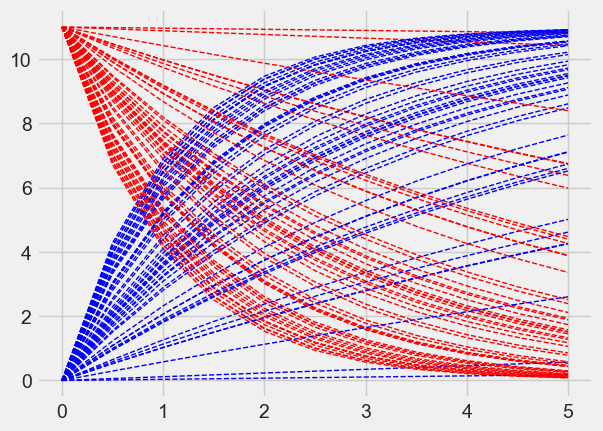

In [80]:
fig, pri = plt.subplots()
plt.style.use(['seaborn-whitegrid'])
plt.rcParams['lines.linewidth'] = 1


for i,j in zip(prior["Ka"],prior["Kb"]):

    sol = odeint(dglsys, y0_array, time_before_feed, args=(i, j))

    pri.plot(time_before_feed, sol[:,1], label="3-OH-PAC modelled", linestyle="--", color="blue")
    pri.plot(time_before_feed, sol[:,0], label="3-OH-PAC modelled", linestyle="--", color="red")


print(posterior.keys())
print(posterior["Ka"])

Ka = posterior["Ka"]
len(Ka)

az.plot_ppc(az.from_pymc3(posterior_predictive=posterior, model=model))


In [5]:
# Test with PyMC3 and differential equation systems
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano


# Change algorithm - check wich algorithm is used
# explicit solver: runge kutta rk45 rk54

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

substrate_array=np.array(substrate_before_feed)
product_array=np.array(product_before_feed)

data_dgl = np.column_stack((substrate_array,product_array))
print(data_dgl)

#print("die data sind",data)

def dadt(y, t, p):
    dadt = -p[0]*y[0]
    dbdt = p[0]*y[1] - p[1]*y[1]
    return [dadt, dbdt]

# test data
time = np.array(time_before_feed)
# time array needs the shape (,11) and the data (11,n) or we need the time as vector and the data as matrix 
ode_model = DifferentialEquation(func=dadt, times=time, n_states=2, n_theta=2)
with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    Kb = pm.Uniform("Kb", 0, 0.0001)
    sigma = pm.Normal("sigma", 0.1)
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=[11, 0], theta=[Ka, Kb])
    # The ode_solution has a shape of (n_times, n_states)

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=data_dgl)

    prior = pm.sample_prior_predictive()
    trace_system = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace_system)

    data_dgl_system = az.from_pymc3(trace=trace_system,posterior_predictive=posterior_predictive)

NameError: name 'substrate_before_feed' is not defined

In [3]:
#az.plot_posterior(data_dgl_system)
print(ode_solution)

NameError: name 'ode_solution' is not defined

In [3]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

y = np.array([[0],[1],[2],[3],[4]])

yobs = np.random.normal(y, 2)

print(yobs)

[[-3.06479043]
 [ 0.03955396]
 [ 5.11360909]
 [ 2.40601481]
 [ 4.71083514]]


In [3]:


%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns



# Generate example data


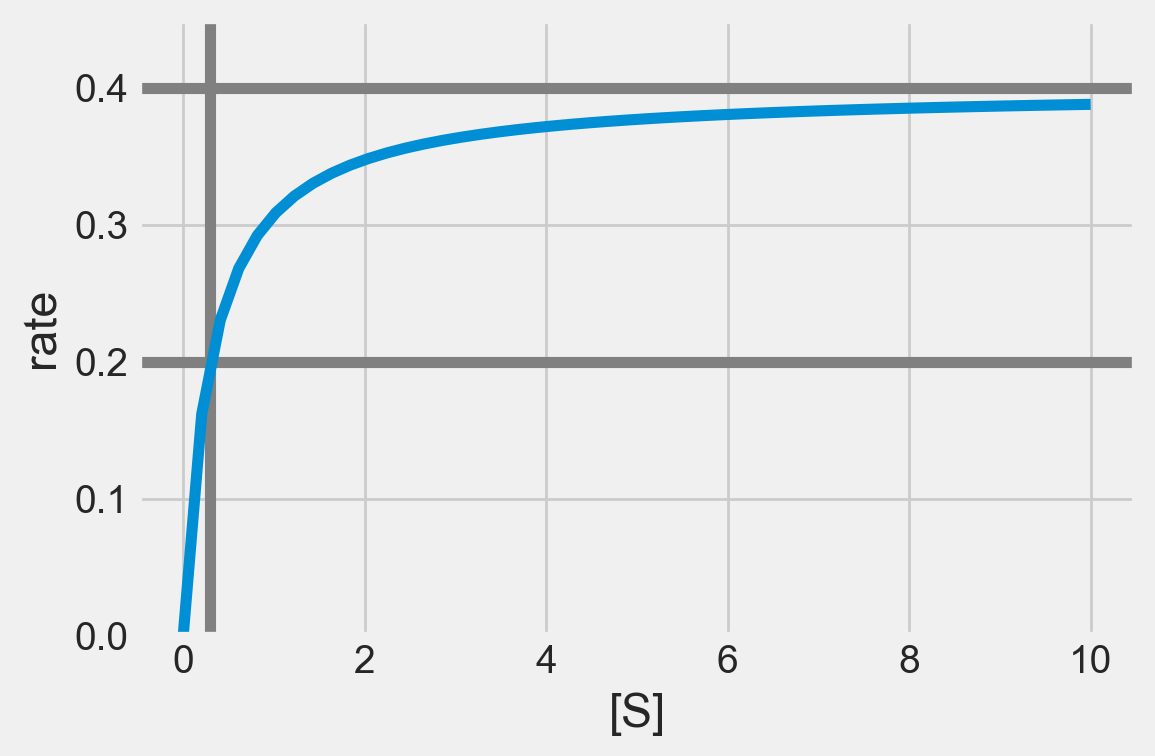

In [27]:
def mm_kinetics(s, Vmax, kM):
    return Vmax*s/(s + kM)


oVmax = 0.4
okm = .3
S = np.linspace(0, 10)

fig, ax = plt.subplots()

ax.axhline(oVmax, color='#808080')
ax.axhline(.5*oVmax, color='#808080')
ax.axvline(okm, color='#808080')
ax.plot(S, mm_kinetics(S, oVmax, okm))

ax.set(xlabel='[S]', ylabel='rate', ylim=(0, .45))

fig.tight_layout()



the rate is [0.10187578 0.19911288 0.24858616 0.29016706 0.31093633 0.32036933
 0.32416435 0.35861662 0.34212328 0.35378976 0.34734269 0.34574386
 0.35114582 0.35532747 0.36299499] <class 'numpy.ndarray'>


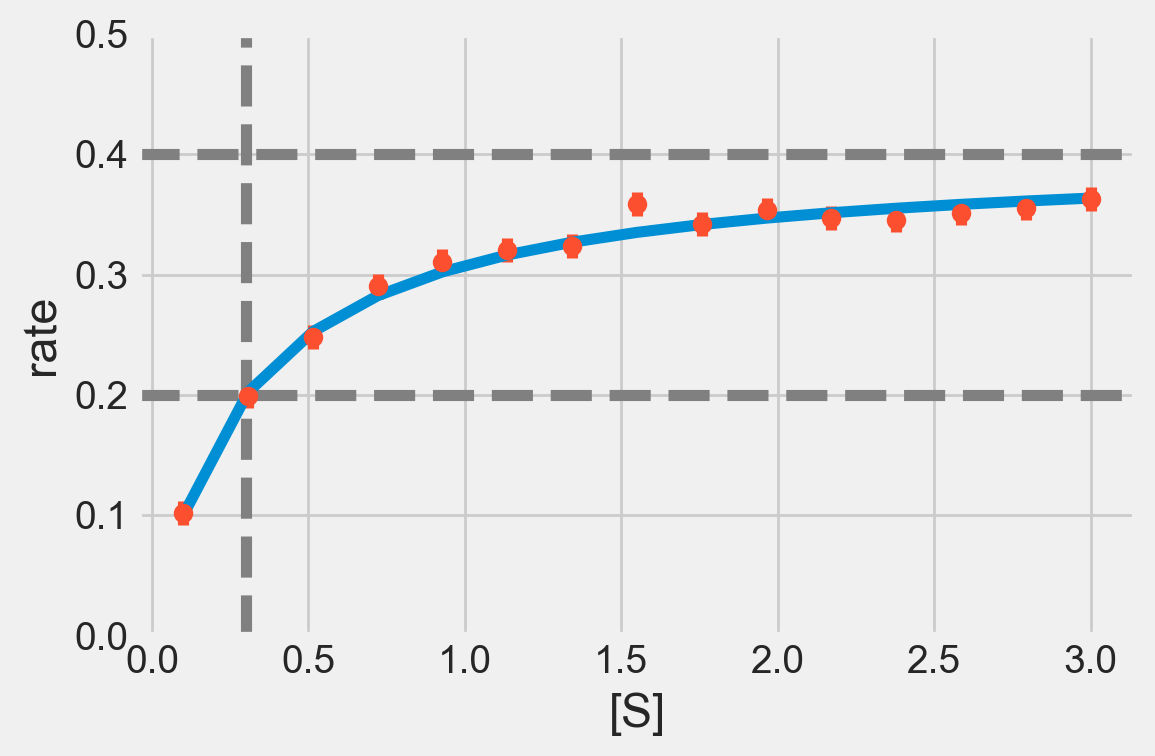

In [30]:


npoints = 15
S = np.linspace(.1, 3, npoints)
sigma = .01
rate = mm_kinetics(S, oVmax, okm) + np.random.normal(scale=sigma, size=(npoints))

print("the rate is",rate, type(rate))

fig, ax = plt.subplots()

ax.axhline(oVmax, color='#808080', linestyle='--')
ax.axhline(.5*oVmax, color='#808080', linestyle='--')
ax.axvline(okm, color='#808080', linestyle='--')
ax.plot(S, mm_kinetics(S, oVmax, okm))
ax.errorbar(S, rate, yerr=np.ones(npoints)*sigma, linestyle='none', marker='o')

ax.set(xlabel='[S]', ylabel='rate', ylim=(0, .5))

fig.tight_layout()


In [9]:
basic_model = pm.Model()


with basic_model:
    # parameters we want to estimate
    vmax = pm.Normal("vmax",0.3, 0.05)
    km = pm.Normal("km",0.2, 0.05)
    # our observable
    f = vmax * S / (km + S)
    # noise
    est_sigma = pm.Uniform('sigma', 0, .1)
    # our likelihood where we add our observed data

    # "mu" = the modelled data
    # "sd" = standard deviation
    # observed = the measured data

    likelihood = pm.Normal('L', mu=f, sd=est_sigma, observed=rate)
    # sampling
    start = pm.find_MAP()
    trace = pm.sample(5000, start=start)


[0.18181818 0.46994536 0.67924528 0.83817427 0.96296296 1.06354515
 1.14634146 1.21568627 1.2746114  1.3253012  1.36936937 1.40803383
 1.44223108 1.47269303 1.5       ]


In [5]:
#ppc = pm.sample_ppc(trace, model=basic_model, samples=50)

AttributeError: module 'pymc3' has no attribute 'sample_ppc'

c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


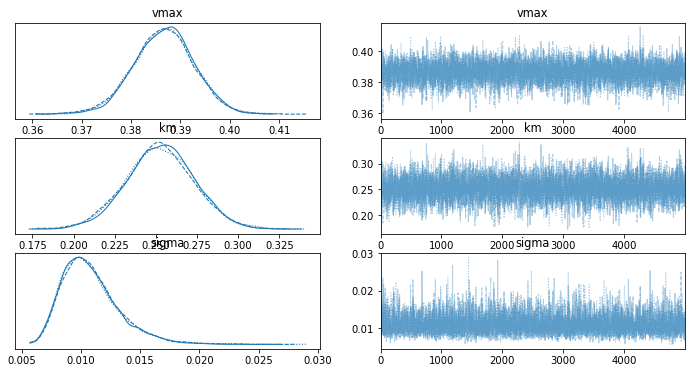

In [19]:
_ = pm.traceplot(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


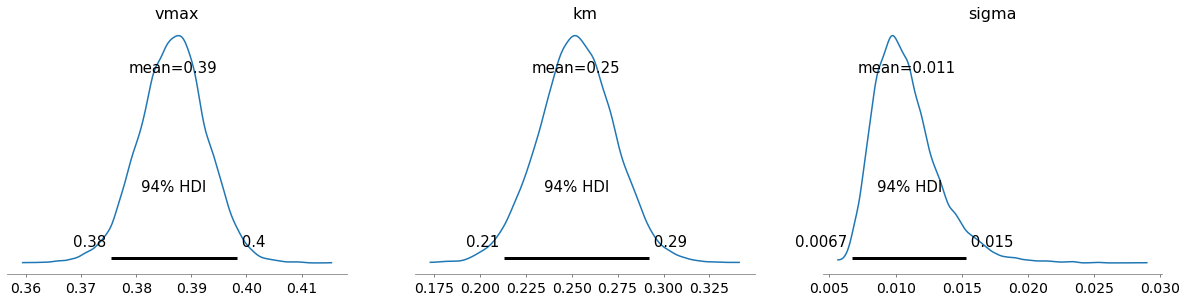

In [20]:
_ = pm.plot_posterior(trace)
